# AutoGrad

In [66]:
import math
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [57]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes = set(); edges = set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR -> left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name = uid, label = "{%s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape = 'record') # for value in the graph create a record for it
        if n._op:
            # if this node is the result of an operation then we create a node to signify it
            dot.node(name = uid + n._op, label = n._op)
            # and connect node to it
            dot.edge(uid+n._op, uid)
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

#### Implemeting __radd__, __rmul__, exp, powers and subtraction in the `Value` class

In [108]:
class Value:

    def __init__(self, data, _children = (), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other,Value) else Value(other) # this functionality allows us to directly perform operation with non Value obejcts by explicitly first converting it to Value object
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out

    def __mul__(self, other):
        other = other if isinstance(other,Value) else Value(other)
        out = Value(self.data * other.data, {self, other}, '*') 
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self, ), f'**{other}')
        def _backward():
            self.grad += (other) * (self.data**(other-1)) * out.grad
        out._backward = _backward
        return out

    def __rmul__(self, other): # other * self
        return self * other
    
    def __radd__(self, other): # other + self
        return self + other
    
    def __rsub__(self, other): # other - self
        return self + (-other)
    
    def __truediv__(self, other): # self / other
        return self * other**-1
    
    def __neg__(self): # -self
        return self * -1
    
    def __sub__(self, other): # self - other
        return self + (-other)
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = Value(t, (self, ), 'tanh')
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out
    
    def backward(self):
        topo = []
        vis = set()
        def build_topo(v):
            if v not in vis:
                vis.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
            return
        self.grad = 1.0
        build_topo(self)
        for node in reversed(topo):
            node._backward()

#### Testing all basic operations with `Value` objects

In [59]:
a = Value(2.0)
a + 1

Value(data=3.0)

In [34]:
a * 2

Value(data=4.0)

In [35]:
2 * a # this does not work as 2.__mul__(a) is not supported, so we need to create a __rmul__ to handle this case

TypeError: unsupported operand type(s) for *: 'int' and 'Value'

In [40]:
2 * a

Value(data=4.0)

In [47]:
a = Value(1.0)
a.exp()

Value(data=2.718281828459045)

In [50]:
a = Value(2.0); b = Value(4.0)
a / b

Value(data=0.5)

In [53]:
a = Value(2.0); b = Value(4.0)
a - b

Value(data=-2.0)

#### Breaking tanh into the constituent parts

In [60]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()

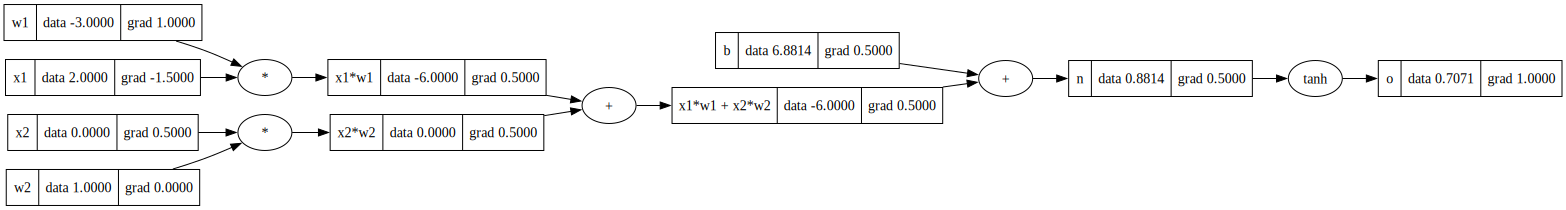

In [61]:
draw_dot(o)

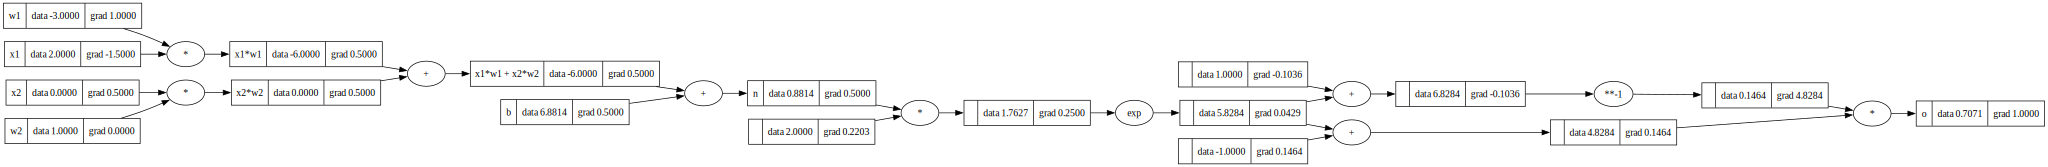

In [62]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
#------------------------------------------------#
e = (2*n).exp()
o = (e-1) / (e+1)
#------------------------------------------------#
o.label = 'o'
o.backward()
draw_dot(o)

#### Implementing the same idea now using PyTorch

In [63]:
import torch

In [65]:
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('-------------------------------------------------')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
-------------------------------------------------
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


### Building a Neural Network

#### Defining a single neuron

In [134]:
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        # print(f"weights: {self.w}")
        self.b = Value(random.uniform(-1,1)) 
        # print(f"bias: {self.b}")

    def __call__(self, x):
        # w * x + b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b) # second parameter is start
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]
    
x = [2.0, 3.0]
n = Neuron(2)
n(x)

Value(data=-0.5970504211924184)

#### Defining a layer of neurons

In [135]:
class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
        # print(f"neurons in the layer: {self.neurons}")
    
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        # params = []
        # for neuron in self.neurons:
        #     ps = neuron.parameters()
        #     params.extend(ps)
        # return params
    
        return [p for neuron in self.neurons for p in neuron.parameters()] # equivalent python way
        
x = [2.0, 3.0]
n = Layer(2, 3)
n(x)

[Value(data=-0.8425691895708571),
 Value(data=0.9930858708385543),
 Value(data=0.45973012205226116)]

#### Defining a neural network i.e. layers of neurons

In [136]:
class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
        # print(f"layers of neurons: {self.layers}")

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

x = [2.0, 3.0, -1.0]
n = MLP(3, [4,4,1])
n(x)

Value(data=-0.8913940183987541)

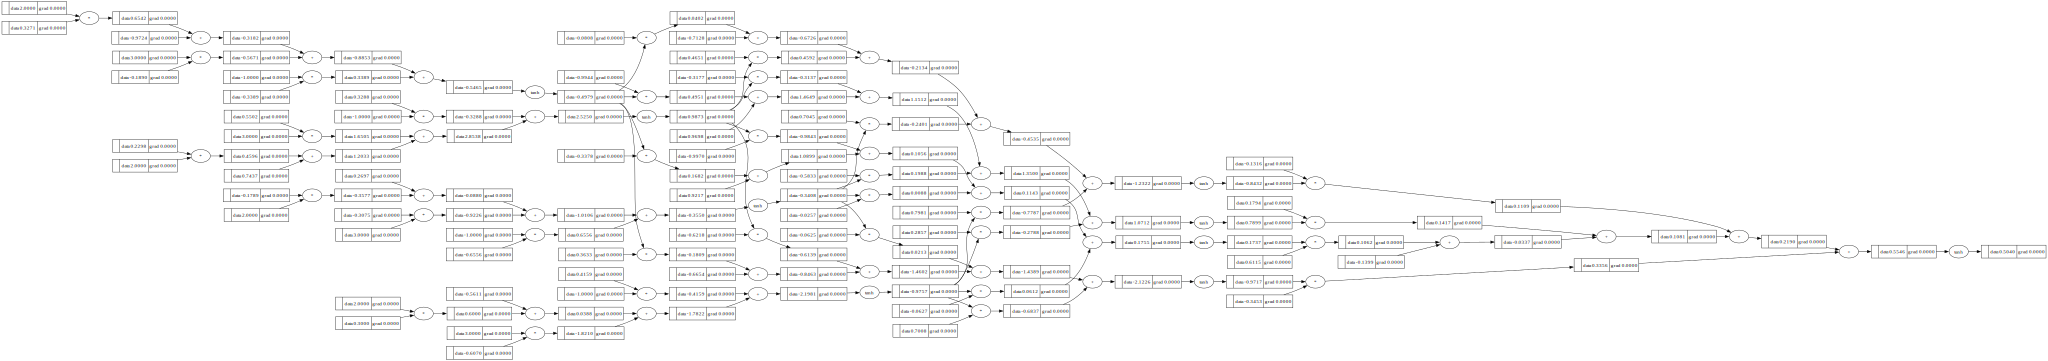

In [104]:
draw_dot(n(x))

#### Creating a tiny dataset to performing binary classification and creating a loss function

In [272]:
n = MLP(3, [4,4,1])

In [273]:
len(n.parameters())

41

Data

In [274]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
    ] # input values
ys = [1.0, -1.0, -1.0, 1.0] # desired values  

Forward Pass

In [156]:
ypreds = [n(x) for x in xs]
ypreds

[Value(data=0.5046909054492047),
 Value(data=0.8213868994469236),
 Value(data=0.7017056785082469),
 Value(data=0.08221428259711668)]

Loss Calculation

In [157]:
loss = sum((ygt - yout)**2 for (ygt, yout) in zip(ys, ypreds))
print(f"MSE Loss: {loss}")

MSE Loss: Value(data=7.300914175957545)


Zero the gradients to before the backward pass (.zero_grad() in PyTorch)

In [271]:
for p in n.parameters():
    p.grad = 0.0

Calculating Gradient

In [257]:
loss.backward()

In [258]:
n.layers[0].neurons[0].w[0].grad

-7.876016716236249

In [259]:
n.layers[0].neurons[0].w[0].data

5.772708642562752

Reducing the loss by taking a step in the opposite direction of the gradient

In [260]:
for p in n.parameters():
    p.data += -0.09*p.grad

In [261]:
n.layers[0].neurons[0].w[0].data

6.481550147024015

Doing the forward pass again

In [262]:
ypreds = [n(x) for x in xs]
ypreds

[Value(data=0.9996225750020166),
 Value(data=-0.9999990807819891),
 Value(data=-0.9956195814135005),
 Value(data=0.9996225490149225)]

Recalculating the loss

In [263]:
loss = sum((ygt - yout)**2 for (ygt, yout) in zip(ys, ypreds))
print(f"MSE Loss: {loss}")

MSE Loss: Value(data=1.9472986713150886e-05)


#### Implementing the training loop

In [275]:
for k in range(100):
    # forward pass
    ypreds = [n(x) for x in xs]
    loss = sum((ygt - yout)**2 for (ygt, yout) in zip(ys, ypreds))
    
    # backward pass
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()
    for p in n.parameters():
        p.data += -0.05*p.grad
    
    print(f"Step: {k} | MSE Loss: {loss.data}")

Step: 0 | MSE Loss: 8.014723518097606
Step: 1 | MSE Loss: 7.504544550063241
Step: 2 | MSE Loss: 7.313819447894883
Step: 3 | MSE Loss: 6.939691308624083
Step: 4 | MSE Loss: 6.089336342327294
Step: 5 | MSE Loss: 4.4620347968610785
Step: 6 | MSE Loss: 3.2201770928145232
Step: 7 | MSE Loss: 2.359248326827441
Step: 8 | MSE Loss: 1.6428440832219329
Step: 9 | MSE Loss: 1.1031767984196865
Step: 10 | MSE Loss: 0.7560566894522944
Step: 11 | MSE Loss: 0.5468307064257787
Step: 12 | MSE Loss: 0.4173186411691124
Step: 13 | MSE Loss: 0.3325555157086594
Step: 14 | MSE Loss: 0.27396865841051665
Step: 15 | MSE Loss: 0.23156404023222188
Step: 16 | MSE Loss: 0.19969529027648714
Step: 17 | MSE Loss: 0.17499924995681293
Step: 18 | MSE Loss: 0.15537348483264124
Step: 19 | MSE Loss: 0.13944707617272295
Step: 20 | MSE Loss: 0.12629305525235693
Step: 21 | MSE Loss: 0.11526475739955708
Step: 22 | MSE Loss: 0.10589872659213545
Step: 23 | MSE Loss: 0.09785492954112972
Step: 24 | MSE Loss: 0.09087871502291622
Step:

In [276]:
ypreds

[Value(data=0.9522403363483817),
 Value(data=-0.9459603113992714),
 Value(data=-0.9412720867035811),
 Value(data=0.9379645533529775)]